In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yfin
import itertools
from pandas_datareader import data as pdr
from pypfopt.efficient_frontier import EfficientFrontier
from matplotlib.ticker import MultipleLocator
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.set()

**FINANCIAL ANALYSIS OF LUMBER PRICES SINCE 1995**

PROJECT DEVELOP BY: Ing. Mateo Gutierrez Acosta

¿Is lumber really a safe asset to hold?

### 1) Obtain UPLOAD DATA
We extracted the daily historical prices of lumber since 1995 in order to create a complete analysis of the behavior and volatility of the price.

The goal of this analysis is to evaluate from a financial standpoint if lumber is a good investment to hold.

In [105]:
excel_file = r"C:\Users\ASUS\Desktop\Personal\Curso Data Analytics\Classes\Data Analytics Projects\Tableu\Lumber Futures Historical Data.xlsx"
df = pd.read_excel(excel_file)
# pd.set_option("display.max_rows", None) #SHOW ALL DATA
# All float with 2 decimals
pd.set_option("display.float_format", "{:,.2f}".format)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-01-06,513.01,506.00,517.50,484.00,NaN,0.98%
1,2024-01-05,508.00,505.50,545.00,470.00,6.86K,1.70%
2,2024-01-04,$499.50,586.00,595.00,492.00,19.04K,-14.62%
3,2024-01-03,585.00,567.50,611.50,555.00,9.14K,3.45%
4,2024-01-02,565.50,563.50,569.00,548.50,9.98K,0.71%
...,...,...,...,...,...,...,...
349,1995-01-05,241.40,255.50,264.90,227.10,7.47K,-5.11%
350,1995-01-04,254.40,267.00,280.00,253.10,6.91K,-5.25%
351,1995-01-03,268.50,294.00,302.00,267.30,6.86K,-10.83%
352,1995-01-02,301.10,308.50,337.90,301.10,7.90K,-2.59%


### 2) SCRUB
In this step we perform the Scrub process: Clean the data, formatting, convert, keep all relative information and manage missing data

In [106]:
df = df.drop(columns=["Vol.", "Change %"])  # Drop the unimportant information

In [107]:
# Formatting errors of the original data
df["Price"] = df.Price.astype(str)



df["Price"] = df.Price.str.replace("$", "").str.replace(",", "").astype(float)


df.head()


df.info()

,Date,Price,Open,High,Low
0,2024-01-06,513.01,506.00,517.50,484.00
1,2024-01-05,508.00,505.50,545.00,470.00
2,2024-01-04,499.50,586.00,595.00,492.00
3,2024-01-03,585.00,567.50,611.50,555.00
4,2024-01-02,565.50,563.50,569.00,548.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    354 non-null    datetime64[ns]
 1   Price   354 non-null    float64       
 2   Open    354 non-null    object        
 3   High    354 non-null    object        
 4   Low     354 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 14.0+ KB


In [108]:
df["Open"] = df.Open.astype(str).str.replace(",", "").astype(float)
df["High"] = df.High.astype(str).str.replace(",", "").astype(float)
df["Low"] = df.Low.astype(str).str.replace(",", "").astype(float)
df["Date"] = df.Date.astype(str)
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%d-%m")
df.Date.dt.month_name()
df.info()
df = df.sort_values(by="Date", ascending=True)
df = df.reset_index(drop=True)
df.head()

0          June
1           May
2         April
3         March
4      February
         ...   
349         May
350       April
351       March
352    February
353     January
Name: Date, Length: 354, dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    354 non-null    datetime64[ns]
 1   Price   354 non-null    float64       
 2   Open    354 non-null    float64       
 3   High    354 non-null    float64       
 4   Low     354 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.0 KB


,Date,Price,Open,High,Low
0,1995-01-01,309.10,318.00,324.00,291.60
1,1995-02-01,301.10,308.50,337.90,301.10
2,1995-03-01,268.50,294.00,302.00,267.30
3,1995-04-01,254.40,267.00,280.00,253.10
4,1995-05-01,241.40,255.50,264.90,227.10


Add close, Year and Month Columns

In [109]:
df["Close"] = df["Open"].shift(-1)
df["Year"] = df.Date.dt.year
df["Month"] = df.Date.dt.month
df.head()

,Date,Price,Open,High,Low,Close,Year,Month
0,1995-01-01,309.10,318.00,324.00,291.60,308.50,1995,1
1,1995-02-01,301.10,308.50,337.90,301.10,294.00,1995,2
2,1995-03-01,268.50,294.00,302.00,267.30,267.00,1995,3
3,1995-04-01,254.40,267.00,280.00,253.10,255.50,1995,4
4,1995-05-01,241.40,255.50,264.90,227.10,237.60,1995,5


rearenge data frame

In [110]:
df = df.reindex(columns=["Date", "Year", "Month", "Price",
                         "Open", "High", "Low", "Close"])

### 3) EXPLORE: Calculate Returns

Calculate the daily return and rise in prices using the build-in formula "pct_change"

In [111]:
df["Return_%"] = (df.Price.pct_change(1)).round(2).astype(
    str) + "%"  # Create a column with the % sign


df["Return"] = (df.Price.pct_change(1)).round(2)

In [112]:
# Handle Missing Data due to formula
df.loc[0, "Return_%"] = "0%"


df.loc[0, "Return"] = 0


df.loc[353, "Close"] = 506.50

was the return positive?

Evaluate if the return of the especific day was positive or negative

In [113]:
for i in range(0, len(df)):
    if df["Return"][i] <= 0:
        df.loc[i, "Result_R"] = "Neg"
    else:
        df.loc[i, "Result_R"] = "Pos"

df.head()

,Date,Year,Month,Price,Open,High,Low,Close,Return_%,Return,Result_R
0,1995-01-01,1995,1,309.10,318.00,324.00,291.60,308.50,0%,0.00,Neg
1,1995-02-01,1995,2,301.10,308.50,337.90,301.10,294.00,-0.03%,-0.03,Neg
2,1995-03-01,1995,3,268.50,294.00,302.00,267.30,267.00,-0.11%,-0.11,Neg
3,1995-04-01,1995,4,254.40,267.00,280.00,253.10,255.50,-0.05%,-0.05,Neg
4,1995-05-01,1995,5,241.40,255.50,264.90,227.10,237.60,-0.05%,-0.05,Neg


Evaluete the Rise of prices in $

In [114]:
df["Rise_Price"] = df.Close - df.Open
df.head(20)

,Date,Year,Month,Price,Open,High,Low,Close,Return_%,Return,Result_R,Rise_Price
0,1995-01-01,1995,1,309.10,318.00,324.00,291.60,308.50,0%,0.00,Neg,-9.50
1,1995-02-01,1995,2,301.10,308.50,337.90,301.10,294.00,-0.03%,-0.03,Neg,-14.50
2,1995-03-01,1995,3,268.50,294.00,302.00,267.30,267.00,-0.11%,-0.11,Neg,-27.00
3,1995-04-01,1995,4,254.40,267.00,280.00,253.10,255.50,-0.05%,-0.05,Neg,-11.50
4,1995-05-01,1995,5,241.40,255.50,264.90,227.10,237.60,-0.05%,-0.05,Neg,-17.90
5,1995-06-01,1995,6,258.00,237.60,263.00,209.60,254.50,0.07%,0.07,Pos,16.90
6,1995-07-01,1995,7,255.70,254.50,288.00,242.10,258.00,-0.01%,-0.01,Neg,3.50
7,1995-08-01,1995,8,287.70,258.00,292.00,250.80,285.50,0.13%,0.13,Pos,27.50
8,1995-09-01,1995,9,274.10,285.50,305.80,267.70,273.00,-0.05%,-0.05,Neg,-12.50
9,1995-10-01,1995,10,251.70,273.00,286.00,231.00,251.00,-0.08%,-0.08,Neg,-22.00


In [115]:
for i in range(0, len(df)):
    if df["Rise_Price"][i] < 0:
        df.loc[i, "Result_P"] = "Neg"
    else:
        df.loc[i, "Result_P"] = "Pos"

df.head()

,Date,Year,Month,Price,Open,High,Low,Close,Return_%,Return,Result_R,Rise_Price,Result_P
0,1995-01-01,1995,1,309.10,318.00,324.00,291.60,308.50,0%,0.00,Neg,-9.50,Neg
1,1995-02-01,1995,2,301.10,308.50,337.90,301.10,294.00,-0.03%,-0.03,Neg,-14.50,Neg
2,1995-03-01,1995,3,268.50,294.00,302.00,267.30,267.00,-0.11%,-0.11,Neg,-27.00,Neg
3,1995-04-01,1995,4,254.40,267.00,280.00,253.10,255.50,-0.05%,-0.05,Neg,-11.50,Neg
4,1995-05-01,1995,5,241.40,255.50,264.90,227.10,237.60,-0.05%,-0.05,Neg,-17.90,Neg


### 4) Data Modeling
In this step we create different data frames to keep only the relevant information and facilitate the process


In [116]:
df_full = df
df = df.drop(columns=["Open", "High", "Low", "Close"])
df.head()

,Date,Year,Month,Price,Return_%,Return,Result_R,Rise_Price,Result_P
0,1995-01-01,1995,1,309.10,0%,0.00,Neg,-9.50,Neg
1,1995-02-01,1995,2,301.10,-0.03%,-0.03,Neg,-14.50,Neg
2,1995-03-01,1995,3,268.50,-0.11%,-0.11,Neg,-27.00,Neg
3,1995-04-01,1995,4,254.40,-0.05%,-0.05,Neg,-11.50,Neg
4,1995-05-01,1995,5,241.40,-0.05%,-0.05,Neg,-17.90,Neg


In [117]:
df_full.head()

,Date,Year,Month,Price,Open,High,Low,Close,Return_%,Return,Result_R,Rise_Price,Result_P
0,1995-01-01,1995,1,309.10,318.00,324.00,291.60,308.50,0%,0.00,Neg,-9.50,Neg
1,1995-02-01,1995,2,301.10,308.50,337.90,301.10,294.00,-0.03%,-0.03,Neg,-14.50,Neg
2,1995-03-01,1995,3,268.50,294.00,302.00,267.30,267.00,-0.11%,-0.11,Neg,-27.00,Neg
3,1995-04-01,1995,4,254.40,267.00,280.00,253.10,255.50,-0.05%,-0.05,Neg,-11.50,Neg
4,1995-05-01,1995,5,241.40,255.50,264.90,227.10,237.60,-0.05%,-0.05,Neg,-17.90,Neg


#### Graphs

Initial graph for a macro overview of the price of lumber since 1995

Create a Monthly price and return chart

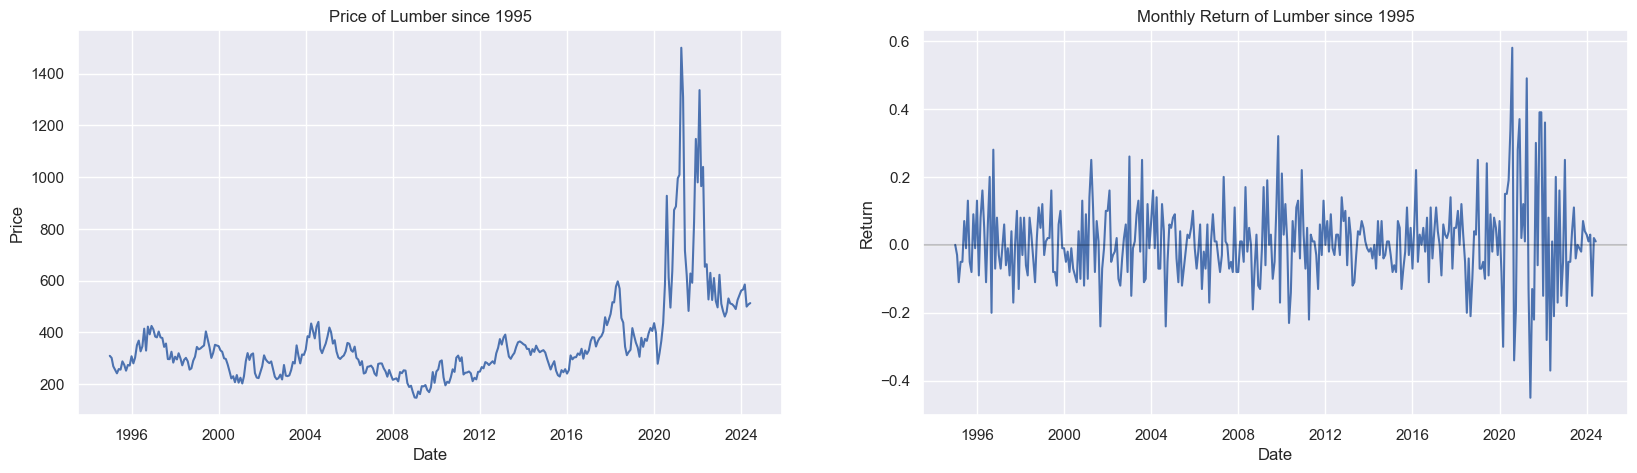

In [150]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=df, x="Date", y="Price")
ax.set_title("Price of Lumber since 1995")
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=df, x="Date", y="Return")
ax.set_title("Monthly Return of Lumber since 1995")
ax.axhline(0, color="Black", alpha=0.2)

Create an annual price and return chart

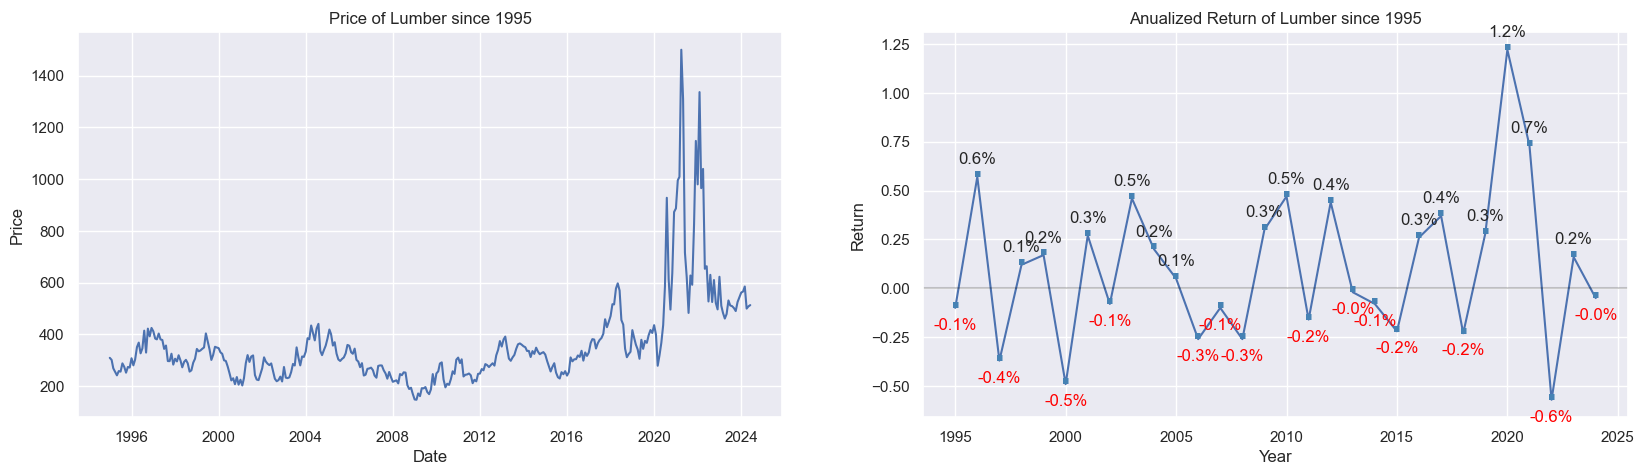

In [151]:
InteractiveShell.ast_node_interactivity = "last_expr"

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)


ax = sns.lineplot(data=df, x="Date", y="Price")


ax.set_title("Price of Lumber since 1995")


plt.subplot(1, 2, 2)


ax = sns.lineplot(data=df, x="Year", y="Return",


                  estimator="sum", errorbar=None)


ax.set_title("Anualized Return of Lumber since 1995")


ax.axhline(0, color="Black", alpha=0.2)


# DATA ON PLOT


for x in range(1995, 2025):

    y = df[df.Year == x]["Return"].sum()

    if y < 0:

        ax.text(x, y-0.05, f"{y.round(1)}%", color="Red",


                horizontalalignment='center', verticalalignment="top")

    else:

        ax.text(x, y+0.05, f"{y.round(1)}%",


                horizontalalignment='center', verticalalignment="bottom")


for x in range(1995, 2025):

    y = df[df.Year == x]["Return"].sum()

    ax.text(x, y, ".", size=40, color="steelblue", horizontalalignment='center',


            verticalalignment="baseline")

Deep dive into the return chart

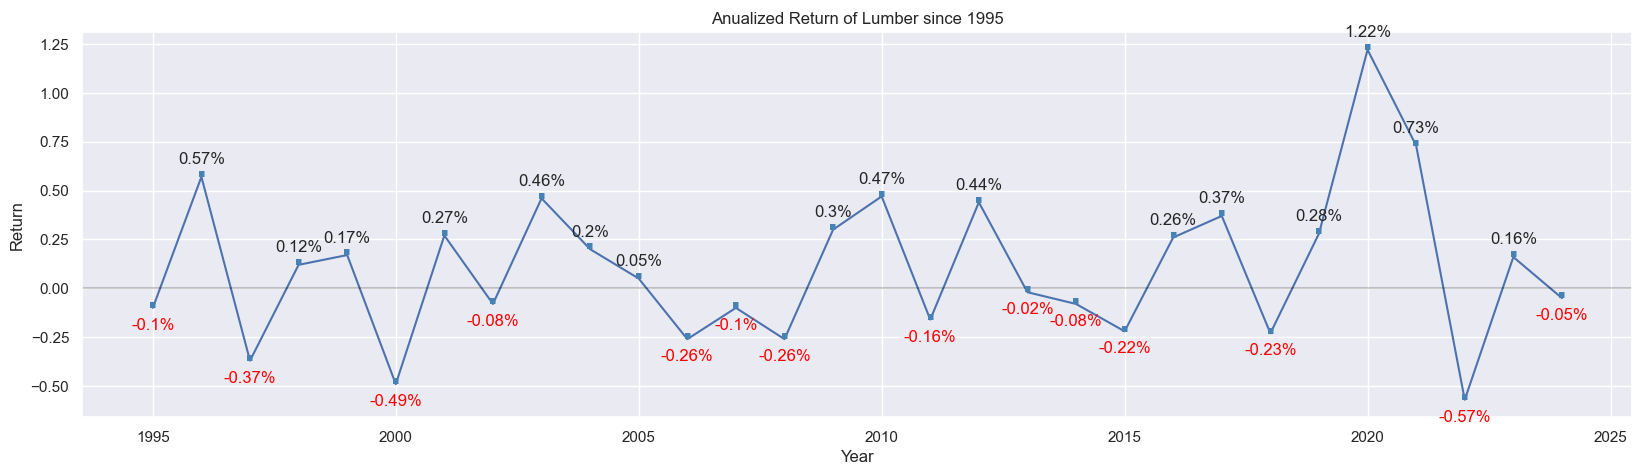

In [120]:

plt.figure(figsize=(20, 5))


plt.subplot(1, 1, 1)


ax = sns.lineplot(data=df, x="Year", y="Return",


                  estimator="sum", errorbar=None)


ax.set_title("Anualized Return of Lumber since 1995")


ax.axhline(0, color="Black", alpha=0.2)


# DATA ON PLOT


for x in range(1995, 2025):

    y = df[df.Year == x]["Return"].sum()

    if y < 0:

        ax.text(x, y-0.05, f"{y.round(2)}%", color="Red",


                horizontalalignment='center', verticalalignment="top")

    else:

        ax.text(x, y+0.05, f"{y.round(2)}%",


                horizontalalignment='center', verticalalignment="bottom")


for x in range(1995, 2025):

    y = df[df.Year == x]["Return"].sum()

    ax.text(x, y, ".", size=40, color="steelblue", horizontalalignment='center',


            verticalalignment="baseline")

BOXCHART

Text(0.5, 1.0, 'BOXCHART Anualized Returns of Lumber since 1995')

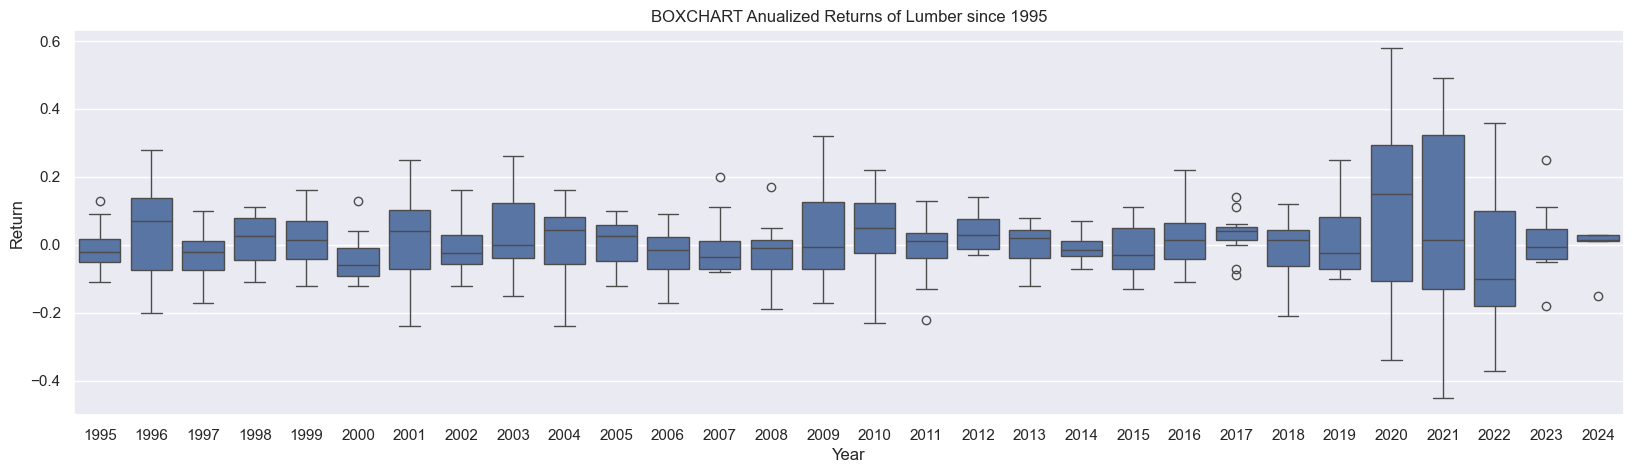

In [121]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 1, 1)
ax = sns.boxplot(data=df,
                 x="Year", y="Return")

ax.set_title("BOXCHART Anualized Returns of Lumber since 1995")

Table

In [122]:
df1 = df.groupby("Year", as_index=False)[["Return", "Rise_Price"]].sum()

# Return
for i in range(0, len(df1)):
    if df1["Return"][i] < 0:
        df1.loc[i, "Result_R"] = "Neg"
    else:
        df1.loc[i, "Result_R"] = "Pos"

# Rise in price
for i in range(0, len(df1)):
    if df1["Rise_Price"][i] < 0:
        df1.loc[i, "Result_P"] = "Neg"
    else:
        df1.loc[i, "Result_P"] = "Pos"

df1 = df1.reindex(
    columns=["Year", "Return", "Result_R", "Rise_Price", "Result_P"])

df1

,Year,Return,Result_R,Rise_Price,Result_P
0,1995,-0.10,Neg,-48.00,Neg
1,1996,0.57,Pos,156.00,Pos
2,1997,-0.37,Neg,-140.50,Neg
3,1998,0.12,Pos,17.50,Pos
4,1999,0.17,Pos,49.00,Pos
5,2000,-0.49,Neg,-144.00,Neg
6,2001,0.27,Pos,38.00,Pos
7,2002,-0.08,Neg,-27.00,Neg
8,2003,0.46,Pos,97.20,Pos
9,2004,0.20,Pos,45.80,Pos


Bar Chart

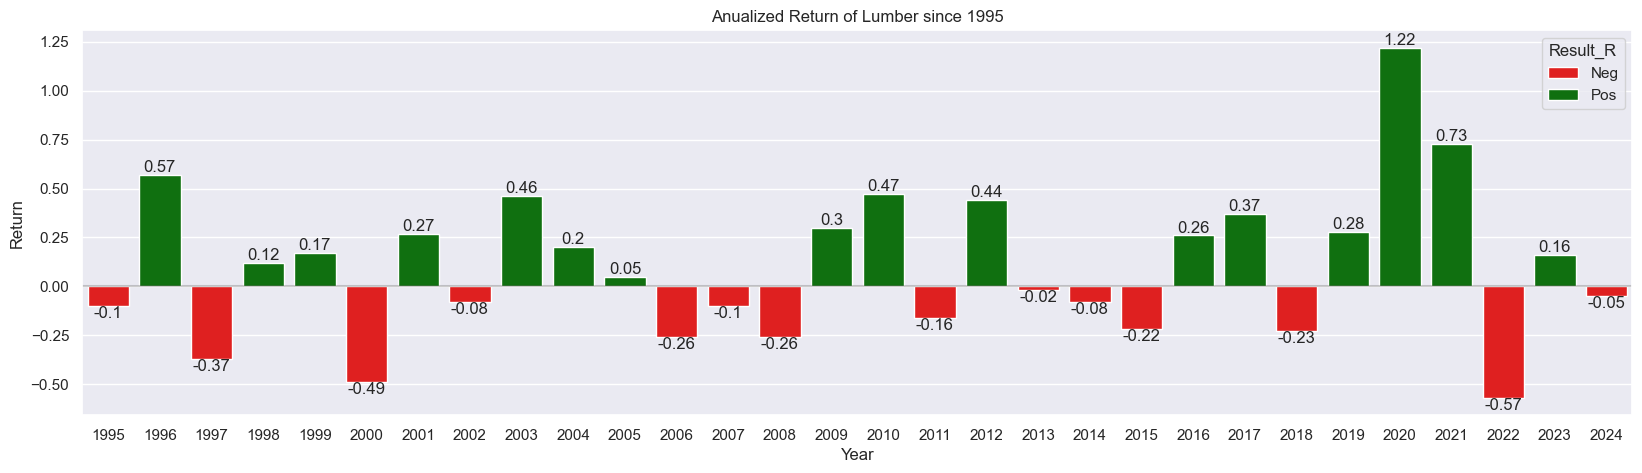

In [123]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 1, 1)
ax = sns.barplot(data=df1,
                 x="Year", y="Return", estimator="sum", errorbar=None, hue="Result_R", palette=["red", "green"])
ax.set_title("Anualized Return of Lumber since 1995")
ax.axhline(0, color="Black", alpha=0.2)

for i in ax.containers:
    ax.bar_label(i,)

### Importan Data about Lumber prices

Min, Max, AVG, Best month, best year and other important data

GENERAL INFO

In [124]:
df.sample(15)

,Date,Year,Month,Price,Return_%,Return,Result_R,Rise_Price,Result_P
187,2010-08-01,2010,8,204.50,-0.02%,-0.02,Neg,-7.90,Neg
281,2018-06-01,2018,6,569.30,-0.05%,-0.05,Neg,-27.40,Neg
261,2016-10-01,2016,10,298.20,-0.11%,-0.11,Neg,-40.20,Neg
155,2007-12-01,2007,12,234.50,-0.08%,-0.08,Neg,-21.90,Neg
146,2007-03-01,2007,3,240.50,-0.08%,-0.08,Neg,-16.20,Neg
33,1997-10-01,1997,10,296.30,-0.0%,-0.00,Neg,3.00,Pos
122,2005-03-01,2005,3,400.70,-0.04%,-0.04,Neg,-15.70,Neg
144,2007-01-01,2007,1,271.20,0.01%,0.01,Pos,0.50,Pos
213,2012-10-01,2012,10,318.80,0.14%,0.14,Pos,41.70,Pos
103,2003-08-01,2003,8,349.50,0.25%,0.25,Pos,69.00,Pos


Statistical information

In [125]:
df[["Price", "Return", "Rise_Price"]].describe()

,Price,Return,Rise_Price
count,354.00,354.00,354.00
mean,358.06,0.01,0.53
std,175.07,0.12,76.39
min,147.00,-0.45,-599.00
25%,258.75,-0.07,-20.22
50%,313.40,0.00,-0.15
75%,380.50,0.07,22.45
max,"1,500.50",0.58,508.00


Number of Positive vs Negative months

In [154]:
df.Result_R.value_counts()

Result_R
Neg    180
Pos    174
Name: count, dtype: int64

**Observation #1:**

<ins>As we can observe</ins> from the data above, the return of lumber is very volatile and it's return is often negative, Which is why it should not be consider as a safe asset to hold

AVG Return per Year Table

In [130]:
df.groupby("Year", as_index=True)[
    ["Price", "Return", "Rise_Price"]].agg([
        "mean", "median", "max", "min"]).T

Year                1995   1996   1997   1998   1999   2000   2001   2002  \
Price      mean   270.58 355.27 353.18 290.54 345.78 268.57 260.54 259.31   
           median 270.00 348.15 367.35 294.30 343.70 262.75 243.80 263.40   
           max    309.10 424.70 411.40 319.00 403.60 346.60 319.70 311.00   
           min    241.40 280.00 282.90 255.80 301.00 205.50 202.20 217.70   
Return     mean    -0.01   0.05  -0.03   0.01   0.01  -0.04   0.02  -0.01   
           median  -0.02   0.07  -0.02   0.03   0.01  -0.06   0.04  -0.03   
           max      0.13   0.28   0.10   0.11   0.16   0.13   0.25   0.16   
           min     -0.11  -0.20  -0.17  -0.11  -0.12  -0.12  -0.24  -0.12   
Rise_Price mean    -4.00  13.00 -11.71   1.46   4.08 -12.00   3.17  -2.25   
           median -10.50  21.70 -11.20   9.90   2.45 -12.70   7.50  -6.00   
           max     27.50 101.00  28.40  29.00  55.00  25.40  56.50  42.00   
           min    -27.00 -82.00 -60.70 -34.00 -41.30 -32.90 -74.70 -41.60   

Year                2003   2004  ...   2015   2016   2017    2018   2019  \
Price      mean   279.55 377.44  ... 265.71 301.68 389.07  454.34 374.27   
           median 279.65 378.80  ... 256.95 307.30 380.60  463.15 376.70   
           max    349.50 440.50  ... 321.80 336.40 458.40  597.10 416.60   
           min    230.60 319.50  ... 229.20 240.40 330.00  311.50 305.50   
Return     mean     0.04   0.02  ...  -0.02   0.02   0.03   -0.02   0.02   
           median   0.00   0.04  ...  -0.03   0.01   0.04    0.01  -0.03   
           max      0.26   0.16  ...   0.11   0.22   0.14    0.12   0.25   
           min     -0.15  -0.24  ...  -0.13  -0.11  -0.09   -0.21  -0.10   
Rise_Price mean     8.10   3.82  ...  -6.23   4.90  11.17   -9.79   6.04   
           median   1.90  15.90  ...  -7.90   5.95  14.30   -2.15  -7.00   
           max     69.00  57.00  ...  27.40  51.50  61.70   59.20  87.30   
           min    -43.00 -99.00  ... -36.50 -40.20 -31.60 -122.00 -41.00   

Year                 2020     2021     2022    2023   2024  
Price      mean    530.62   892.77   745.67  513.92 538.75  
           median  465.65   855.75   641.75  509.75 537.25  
           max     928.00 1,500.50 1,336.70  622.50 585.00  
           min     278.50   482.80   496.50  461.00 499.50  
Return     mean      0.10     0.06    -0.05    0.01  -0.01  
           median    0.15     0.01    -0.10   -0.01   0.01  
           max       0.58     0.49     0.36    0.25   0.03  
           min      -0.34    -0.45    -0.37   -0.18  -0.15  
Rise_Price mean     39.09    21.49   -54.62    5.79  -6.42  
           median   45.60    13.25   -64.75   -5.50   2.25  
           max     336.00   508.00   386.20  151.50  18.50  
           min    -310.80  -599.00  -393.80 -126.50 -80.50  

[12 rows x 30 columns]

BEHEVIOR OVER THE PAST 5 YEARS

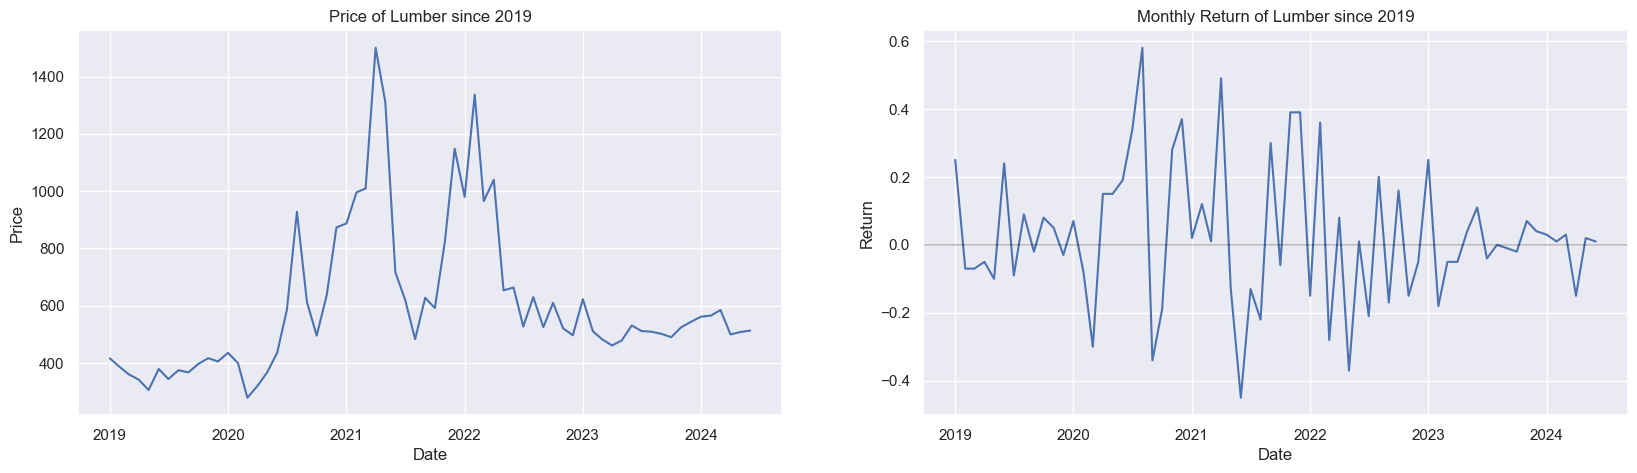

In [131]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
ax = sns.lineplot(data=df[df.Year > (2024-6)], x="Date", y="Price")
ax.set_title(f"Price of Lumber since {(2024-5)}")
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=df[df.Year > (2024-6)], x="Date", y="Return")
ax.set_title(f"Monthly Return of Lumber since {(2024-5)}")
ax.axhline(0, color="Black", alpha=0.2)

In [158]:
InteractiveShell.ast_node_interactivity = "all"
df[df.Year > (2024-6)].Result_R.value_counts()

Result_R
Pos    35
Neg    31
Name: count, dtype: int64

In [159]:
df[df.Year > (2024-6)][["Price", "Return", "Rise_Price"]].describe()

,Price,Return,Rise_Price
count,66.00,66.00,66.00
mean,604.84,0.03,2.65
std,261.16,0.21,167.30
min,278.50,-0.45,-599.00
25%,435.55,-0.09,-41.67
50%,523.00,0.01,2.25
75%,635.10,0.14,54.88
max,"1,500.50",0.58,508.00


In [134]:
df[df.Year > (2024-6)].groupby("Year", as_index=True)[
    ["Price", "Return", "Rise_Price"]].agg([
        "mean", "median", "max", "min"]).T

Year                2019    2020     2021     2022    2023   2024
Price      mean   374.27  530.62   892.77   745.67  513.92 538.75
           median 376.70  465.65   855.75   641.75  509.75 537.25
           max    416.60  928.00 1,500.50 1,336.70  622.50 585.00
           min    305.50  278.50   482.80   496.50  461.00 499.50
Return     mean     0.02    0.10     0.06    -0.05    0.01  -0.01
           median  -0.03    0.15     0.01    -0.10   -0.01   0.01
           max      0.25    0.58     0.49     0.36    0.25   0.03
           min     -0.10   -0.34    -0.45    -0.37   -0.18  -0.15
Rise_Price mean     6.04   39.09    21.49   -54.62    5.79  -6.42
           median  -7.00   45.60    13.25   -64.75   -5.50   2.25
           max     87.30  336.00   508.00   386.20  151.50  18.50
           min    -41.00 -310.80  -599.00  -393.80 -126.50 -80.50

**TOP AND WORST 5 OF THE LAST 5 YEARS**

<ins>MONTHLY</ins>

Price

In [160]:
df[df.Year > (2024-6)][["Year", "Month", "Price", "Return"]
                       ].nlargest(5, columns="Price")

df[df.Year > (2024-6)][["Year", "Month",  "Price", "Return"]
                       ].nsmallest(5, columns="Price")

,Year,Month,Price,Return
315,2021,4,"1,500.50",0.49
325,2022,2,"1,336.70",0.36
316,2021,5,"1,309.50",-0.13
323,2021,12,"1,147.90",0.39
327,2022,4,"1,039.70",0.08


,Year,Month,Price,Return
302,2020,3,278.50,-0.30
292,2019,5,305.50,-0.10
303,2020,4,319.70,0.15
291,2019,4,341.20,-0.05
294,2019,7,343.90,-0.09


Return

In [161]:
df[df.Year > (2024-6)][["Year", "Month",  "Price", "Return"]
                       ].nlargest(5, columns="Return")

df[df.Year > (2024-6)][["Year", "Month",  "Price", "Return"]
                       ].nsmallest(5, columns="Return")

,Year,Month,Price,Return
307,2020,8,928.00,0.58
315,2021,4,"1,500.50",0.49
322,2021,11,824.50,0.39
323,2021,12,"1,147.90",0.39
311,2020,12,873.10,0.37


,Year,Month,Price,Return
317,2021,6,716.00,-0.45
328,2022,5,653.50,-0.37
308,2020,9,612.20,-0.34
302,2020,3,278.50,-0.30
326,2022,3,965.30,-0.28


Rise of price

In [163]:
df[df.Year > (2024-6)][["Year", "Month",  "Price", "Return", "Rise_Price"]
                       ].nlargest(5, columns="Rise_Price")

df[df.Year > (2024-6)][["Year", "Month",  "Price", "Return", "Rise_Price"]
                       ].nsmallest(5, columns="Rise_Price")

,Year,Month,Price,Return,Rise_Price
315,2021,4,"1,500.50",0.49,508.00
325,2022,2,"1,336.70",0.36,386.20
307,2020,8,928.00,0.58,336.00
323,2021,12,"1,147.90",0.39,276.40
322,2021,11,824.50,0.39,259.40


,Year,Month,Price,Return,Rise_Price
317,2021,6,716.00,-0.45,-599.00
326,2022,3,965.30,-0.28,-393.80
328,2022,5,653.50,-0.37,-389.10
308,2020,9,612.20,-0.34,-310.80
316,2021,5,"1,309.50",-0.13,-205.60


<ins>ANNUAL</ins>

In [168]:
df[df.Year > (2024-6)].groupby("Year")[["Return", "Rise_Price"]
                                       ].agg(["sum",
                                              "mean", "median", "max", "min"]).T

Year                2019    2020    2021    2022    2023   2024
Return     sum      0.28    1.22    0.73   -0.57    0.16  -0.05
           mean     0.02    0.10    0.06   -0.05    0.01  -0.01
           median  -0.03    0.15    0.01   -0.10   -0.01   0.01
           max      0.25    0.58    0.49    0.36    0.25   0.03
           min     -0.10   -0.34   -0.45   -0.37   -0.18  -0.15
Rise_Price sum     72.50  469.10  257.90 -655.50   69.50 -38.50
           mean     6.04   39.09   21.49  -54.62    5.79  -6.42
           median  -7.00   45.60   13.25  -64.75   -5.50   2.25
           max     87.30  336.00  508.00  386.20  151.50  18.50
           min    -41.00 -310.80 -599.00 -393.80 -126.50 -80.50

Price and return

In [172]:

df[df.Year > (2024-6)][["Year", "Price", "Return"]
                       ].nsmallest(5, columns="Price")

df[df.Year > (2024-6)][["Year", "Price", "Return"]
                       ].nsmallest(5, columns="Return")

,Year,Price,Return
302,2020,278.50,-0.30
292,2019,305.50,-0.10
303,2020,319.70,0.15
291,2019,341.20,-0.05
294,2019,343.90,-0.09


,Year,Price,Return
317,2021,716.00,-0.45
328,2022,653.50,-0.37
308,2020,612.20,-0.34
302,2020,278.50,-0.30
326,2022,965.30,-0.28


**ANNUALIZED BEHAVIOR OF THE LAST 5 YEARS**

<Figure size 2000x500 with 0 Axes>

<Axes: >

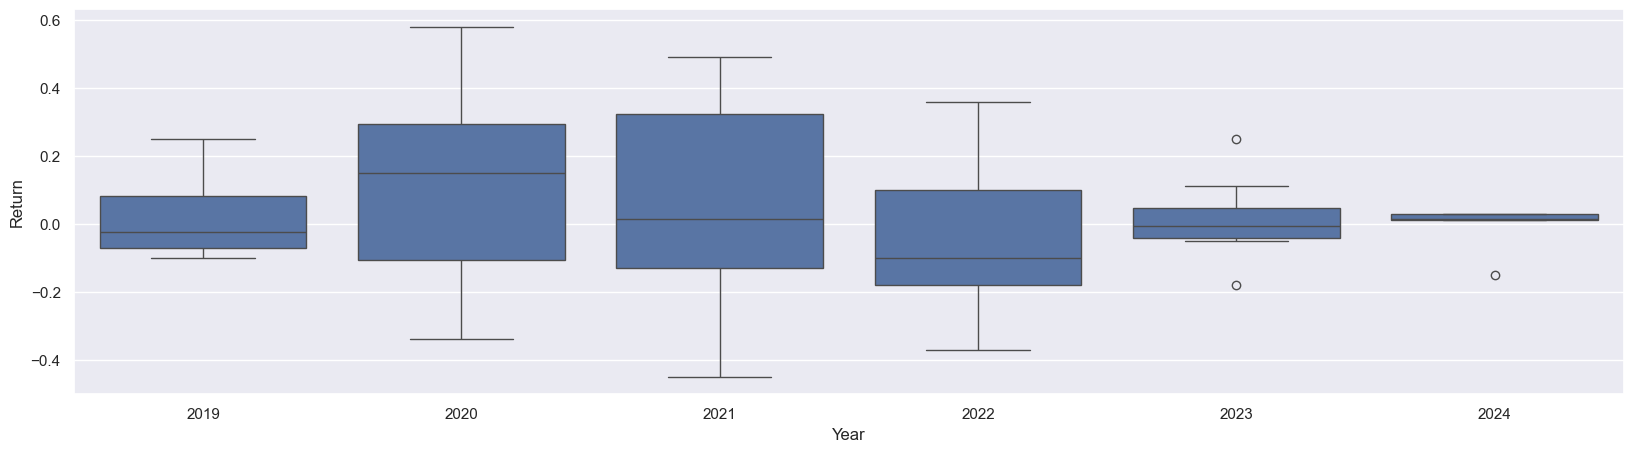

In [170]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 1, 1)
ax = sns.boxplot(data=df[df.Year > (2024-6)],


                 x="Year", y="Return")

<Figure size 2000x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Price of Lumber since 2019')

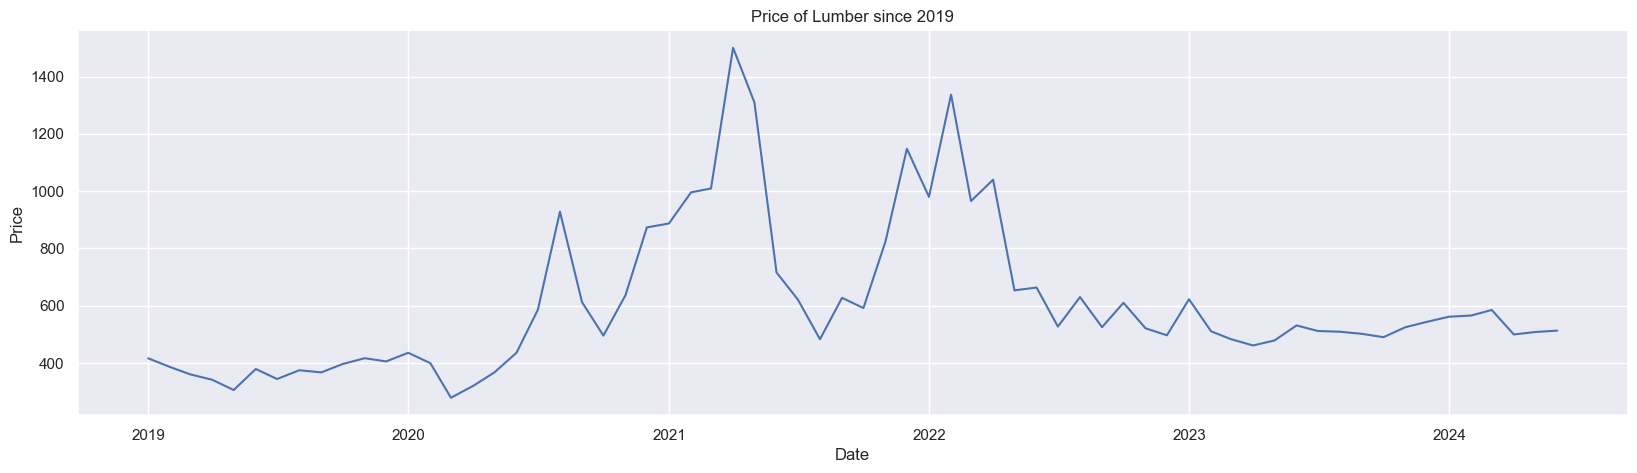

In [171]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 1, 1)
ax = sns.lineplot(data=df[df.Year > (2024-6)], x="Date", y="Price")


ax.set_title(f"Price of Lumber since {(2024-5)}")

BARPLOT ANUALIZED

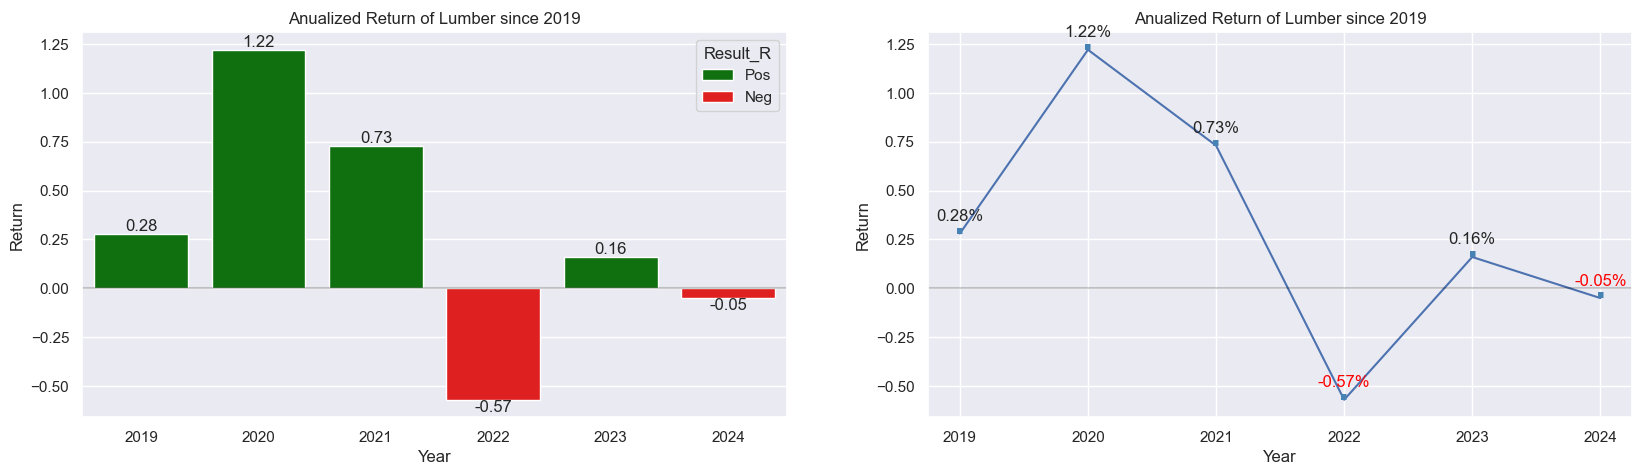

In [142]:

plt.figure(figsize=(20, 5))


# BARPLOT


plt.subplot(1, 2, 1)

ax = sns.barplot(data=df1[df1["Year"] > (2024-6)],

                 x="Year", y="Return", errorbar=None, hue="Result_R", palette=["green", "red"])

ax.set_title("Anualized Return of Lumber since 2019")

ax.axhline(0, color="Black", alpha=0.2)


for i in ax.containers:

    ax.bar_label(i,)


# lINEPLOT

plt.subplot(1, 2, 2)

ax = sns.lineplot(data=df[df.Year > (2024-6)],

                  x="Year", y="Return", estimator="sum", errorbar=None)

ax.set_title(f"Anualized Return of Lumber since {(2024-5)}")

ax.axhline(0, color="Black", alpha=0.2)


# DATA ON PLOT

for x in range(2019, 2025):

    y = df[df.Year == x]["Return"].sum()

    if y < 0:

        ax.text(x, y+0.05, f"{y.round(2)}%", color="Red",

                horizontalalignment='center', verticalalignment="bottom")

    else:

        ax.text(x, y+0.05, f"{y.round(2)}%",

                horizontalalignment='center', verticalalignment="bottom")


for x in range(2019, 2025):

    y = df[df.Year == x]["Return"].sum()

    ax.text(x, y, ".", size=40, color="steelblue", horizontalalignment='center',

            verticalalignment="baseline")

MAX AND MIN ANNUAL RETURN

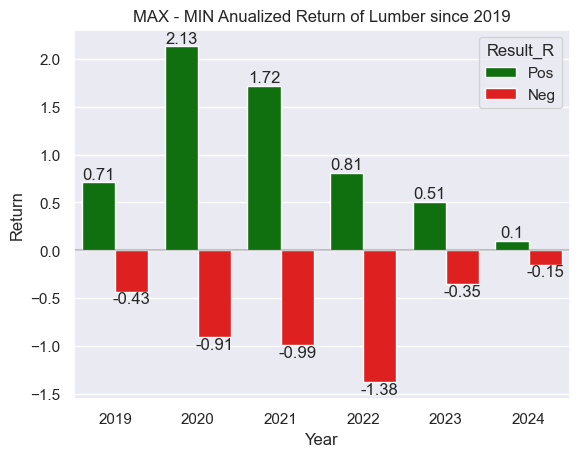

In [143]:
# plt.figure(figsize=(20, 5))
# plt.subplot(1, 1, 1)
ax = sns.barplot(data=df[df.Year > (2024-6)],
                 x="Year", y="Return", estimator="sum", errorbar=None, hue="Result_R", palette=["green", "red"])
ax.set_title(f"MAX - MIN Anualized Return of Lumber since {(2024-5)}")
ax.axhline(0, color="Black", alpha=0.2)
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.text(0, 0.25, "Siuu", color="Red",
#         horizontalalignment='center', verticalalignment="bottom")
for i in ax.containers:
    ax.bar_label(i,)

Compare data whole, since 2019 and less than 2019

In [180]:
print("---COMPLETE DATA SINCE 1995---")
display(df[["Price", "Return", "Rise_Price"]].agg([
    "mean", "median", "max", "min"]))

print("-----DATA BEFORE 2019-----")
display(df[df.Year <= (2024-6)][["Price", "Return", "Rise_Price"]].agg([
    "mean", "median", "max", "min"]))

print("-----DATA SINCE 2019-----")
display(df[df.Year > (2024-6)][["Price", "Return", "Rise_Price"]].agg([
    "mean", "median", "max", "min"]))

---COMPLETE DATA SINCE 1995---


,Price,Return,Rise_Price
mean,358.06,0.01,0.53
median,313.40,0.00,-0.15
max,"1,500.50",0.58,508.00
min,147.00,-0.45,-599.00


-----DATA BEFORE 2019-----


,Price,Return,Rise_Price
mean,301.50,0.00,0.05
median,297.10,0.00,-0.80
max,597.10,0.32,101.00
min,147.00,-0.24,-122.00


-----DATA SINCE 2019-----


,Price,Return,Rise_Price
mean,604.84,0.03,2.65
median,523.00,0.01,2.25
max,"1,500.50",0.58,508.00
min,278.50,-0.45,-599.00


### COMPLETE VIEW OF RETURNS OVER THE YEARS

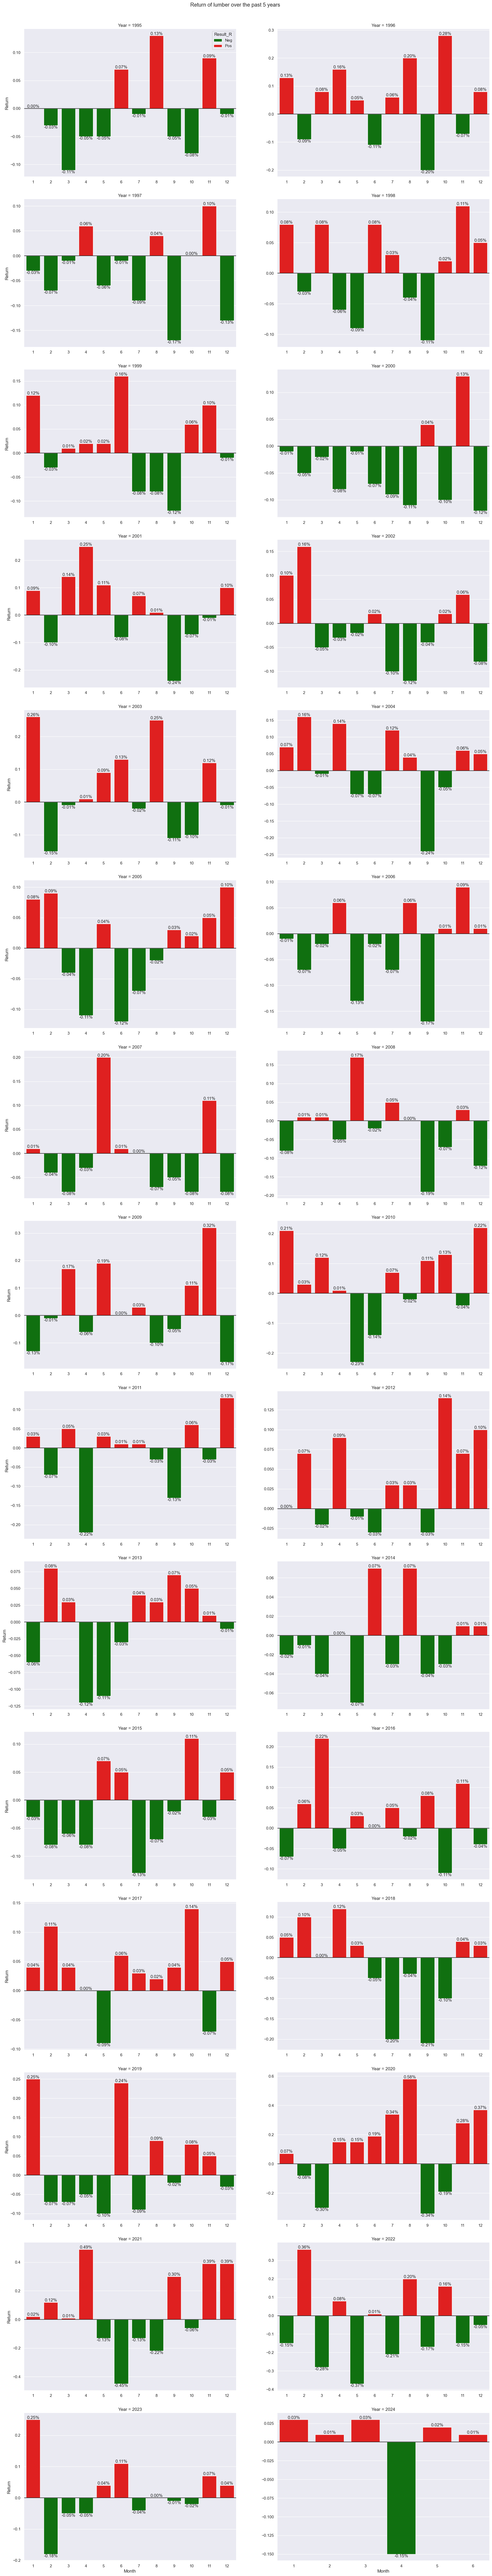

In [145]:
g = sns.catplot(data=df, y="Return", x="Month",
                kind="bar", errorbar=None, col="Year", col_wrap=2, hue="Result_R", palette=["green", "red"], sharey=False, sharex=False, legend_out=False)

g.fig.subplots_adjust(top=0.97)
g.fig.suptitle('Return of lumber over the past 5 years')
g.fig.set_size_inches(20, 100)

# iterate through axes
for ax in g.axes.flatten():  # Ravel()is for convert matrix into list flat

    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.2f}%' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
        ax.axhline(0, color="Black", alpha=0.5)
    ax.margins(x=0.01)

TOP 5 YEARS WITH THE MOST AND WORST RETURNS

In [147]:
print("The best five years")
display(df[["Year", "Return"]].nlargest(5, columns="Return"))
print("The worst five years")


display(df[["Year", "Return"]].nsmallest(5, columns="Return"))

The best five years


,Year,Return
307,2020,0.58
315,2021,0.49
322,2021,0.39
323,2021,0.39
311,2020,0.37


The worst five years


,Year,Return
317,2021,-0.45
328,2022,-0.37
308,2020,-0.34
302,2020,-0.30
326,2022,-0.28


<Axes: >

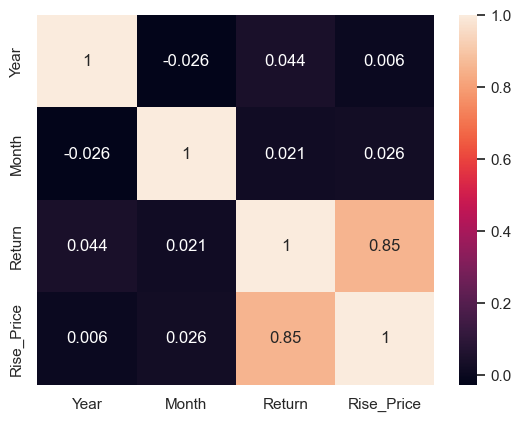

In [149]:
sns.heatmap(df[["Year", "Month", "Return", "Rise_Price"]].corr(), annot=True)

### 5) CONCLUSION

Based on the historical data analyzed since 1995, lumber does not appear to be a safe asset to hold. While it has shown periods of growth, the long-term trend has been downward, particularly when considering the impact of economic downturns, natural disasters, and supply chain disruptions. Contrary to popular belief, lumber's volatility and potential for loss make it a risky investment. Investors seeking stability and consistent returns should consider alternative options.
